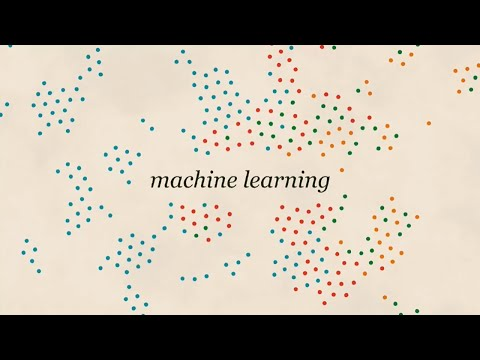

In [1]:
import IPython

IPython.display.YouTubeVideo("59bMh59JQDo")

Let's get started by installing the relevant dependencies.

In [2]:
# MIT introduction to deep learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import other packages
import os
import random
import functools
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\RTC\anaconda3\envs\jupyter_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# 2.1 Datasets

2.1 Datasets
We'll be using three datasets in this lab. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about the potential bias of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender.

Positive training data: CelebA Dataset. A large-scale (over 200K images) of celebrity faces.

Negative training data: ImageNet. Many images across many different categories. We'll take negative examples from a variety of
non-human categories. Fitzpatrick Scale skin type classification system, with each image labeled as "Lighter'' or "Darker''.
Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [3]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data : both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)
    
# Instantiate a TrainingDatasetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

Using cached training data from C:\Users\RTC\.cache\mitdeeplearning\train_face.h5
Opening C:\Users\RTC\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [4]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [5]:
B, C, H, W = images.shape
print(B, C, H, W)

100 3 64 64


Play around with displaying images to get a sense of what the training data actually looks like!

In [6]:
# some key points
# np.where
arr = np.array([1, 2, 3, 0, 0, 3, 0, 1])

idx = np.where(arr == 0) # np.where returs tuples [[indx], ]
idx1 = np.where(arr == 0)[0]

print(idx)
print(idx1)

# why in the next we used transpose(0, 2, 3, 1)
# first of all the samples is on the next format (N, C, H, W) 
# but in order to use plt.imshow it gotta be on this format (N, H, W, C)
# So this why the paramters in transpose looked like this (0, 2, 3, 1)

(array([3, 4, 6]),)
[3 4 6]


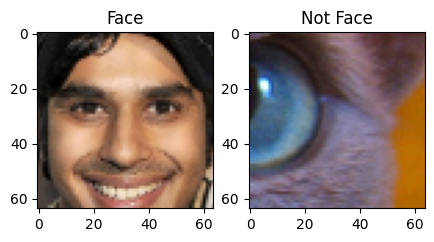

In [7]:
face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)


idx_face = 23  # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

In [8]:
print(images.shape)

(100, 3, 64, 64)


## Thinking about bias
Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA and achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about latent variables, variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term latent space to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier biased if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab.

## 2.2 CNN for facial detection

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

## Define and train the CNN model
Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets by leveraging PyTorch's automatic differentiation (torch.autograd) by using the loss.backward() and optimizer.step() functions.

In [9]:
n_filters = 12  # base number of convolutional filters
in_channles = images.shape[1]  # RGB -> 3

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


def make_standard_classifier(n_outputs):
    model = nn.Sequential(
        ConvBlock(in_channles, n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
        ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
        nn.Flatten(),
        nn.Linear(H // 16 * W // 16 * 6*n_filters, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, n_outputs)
    )
    return model



standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)


Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

Now let's train the standard CNN!

In [10]:
# Train the standard CNN
loss_function = nn.BCEWithLogitsLoss()

# Training parameters
params = dict(
    batch_size = 64,
    epochs = 2,
    learning_rate = 5e-4
)

# Define the optimizer
optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params['learning_rate']
)


In [11]:
# Training Loop
standard_classifier.train()

for epoch in range(params['epochs']):
    total_loss = 0.0
    correct_pred = 0
    total_pred = 0
    
    for _ in range(loader.get_train_size() // params['batch_size']):
        
        images, labels = loader.get_batch(params['batch_size'])
        
        images = torch.from_numpy(images).float().to(device)
        labels = torch.from_numpy(labels).float().to(device)
        
        # Forward pass
        logits = standard_classifier(images)
        
        # Loss
        loss = loss_function(logits, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Predictions
        preds = (torch.sigmoid(logits) > 0.5).long()
        correct_pred += (preds == labels).sum().item()
        total_pred += labels.size(0)
        
        # Compute the loss
        total_loss += loss.item() * labels.size(0)
    
    # epoch metrics
    epoch_loss = total_loss / total_pred
    epoch_acc = correct_pred / total_pred
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1, Loss: 0.0221, Accuracy: 0.9921
Epoch 2, Loss: 0.0079, Accuracy: 0.9976


### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.

In [12]:
### Evaluation of standard CNN ###

# set the model to eval mode
standard_classifier.eval()

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
batch_x = torch.from_numpy(batch_x).float().to(device)
batch_y = torch.from_numpy(batch_y).float().to(device)

with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)
    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())

print(
    "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
        acc_standard.item()
    )
)

Standard CNN accuracy on (potentially biased) training set: 0.9962


We will also evaluate our networks on an independent test dataset containing faces that were not seen during training. For the test data, we'll look at the classification accuracy across four different demographics, based on the Fitzpatrick skin scale and sex-based labels: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female.

Let's take a look at some sample faces in the test set.

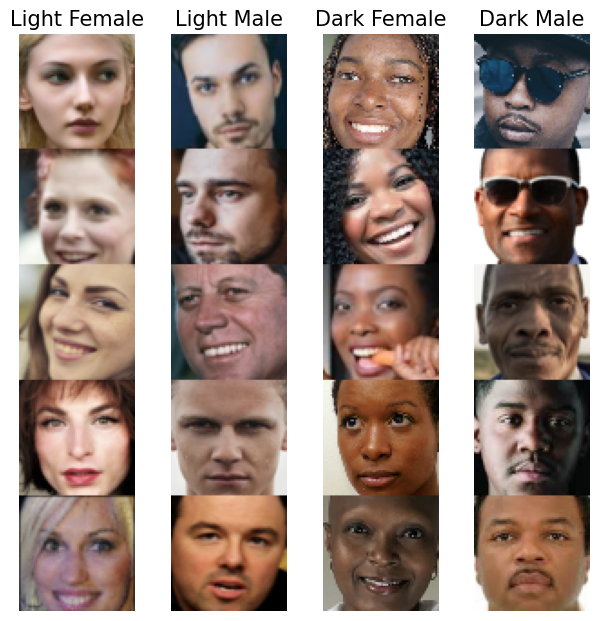

In [13]:
# Load test dataset and plot samples

test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained.

Text(0.5, 1.0, 'Standard classifier predictions')

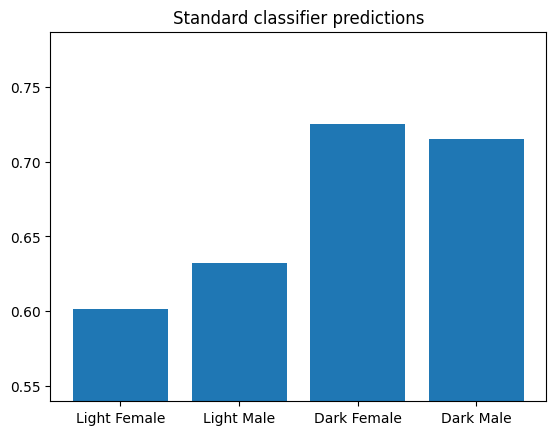

In [14]:
### Evaluate the standard CNN on the test data ###

standard_classifier_probs_list = []  # store each demographic's probabilities

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x)  # [B, 1]
        probs = torch.sigmoid(logits)  # [B, 1]
        probs = torch.squeeze(probs, dim=-1)  # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)


# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)  # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

## 2.3 Mitigating algorithmic bias
Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

How could we overcome this? A naive solution -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then manually even out the data with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different features that are imbalanced within the training data.

Instead, let's actually learn these features in an unbiased, unsupervised manner, without the need for any annotation, and then train a classifier fairly with respect to these features. In the rest of this lab, we'll do exactly that.

## 2.4 Variational autoencoder (VAE) for learning latent structure
As you saw, the accuracy of the CNN varies across the four demographics we looked at. To think about why this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are rare in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem.

Our goal is to train a debiased version of this classifier -- one that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that learns a representation of the underlying latent space to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, more frequently during training. The key design requirement for our model is that it can learn an encoding of the latent features in the face data in an entirely unsupervised way. To achieve this, we'll turn to variational autoencoders (VAEs).

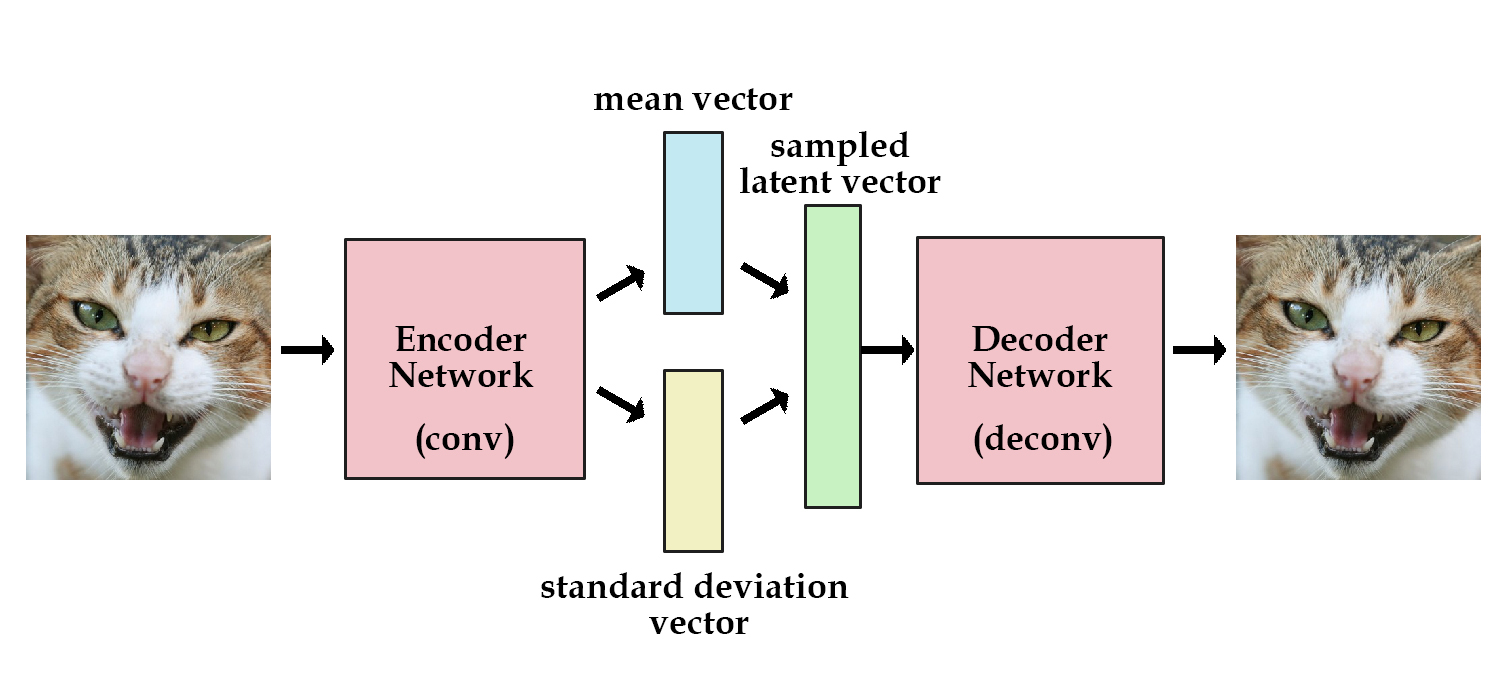

As shown in the schematic above and in Lecture 4, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn.

Let's formalize two key aspects of the VAE model and define relevant functions for each.

In [15]:
# Loss function
def vae_loss_function(x, x_rec, mu, logsigma, kl_weight=0.0005):
    
    # KL Divergence
    latent_loss = -0.5 * torch.mean(
        1 + logsigma - mu.pow(2) - torch.exp(logsigma)
    )
    
    # Reconstruction loss (Mean Absolute Error pixel_wise)
    rec_loss = torch.mean(
        torch.abs(x - x_rec),
        dim=(1, 2, 3) # average over channel, height, width
    )
    
    rec_loss = torch.mean(rec_loss) # for the whole batch
    
    # Total VAE loss
    vae_loss = rec_loss + kl_weight * latent_loss
    
    return vae_loss
    

Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to train a debiased facial classifier.

## VAEs: reparameterization

In [16]:
## Our goal is to implement the following formula
# z = mu + sigma * epsilon

def sampling(z_mean, z_logsigma):
    # Generate random noise
    eps = torch.rand_like(z_mean)
    
    # Standard deviation
    sigma = torch.exp(0.5 * z_logsigma)
    
    # Reparameterization trick
    z = z_mean + sigma * eps
    
    return z

## 2.5 Debiasing variational autoencoder (DB-VAE)

Now, we'll use the general idea behind the VAE architecture to build a model, termed a debiasing variational autoencoder or DB-VAE, to mitigate (potentially) unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.

## The DB-VAE model
The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

A general schematic of the DB-VAE approach is shown here:

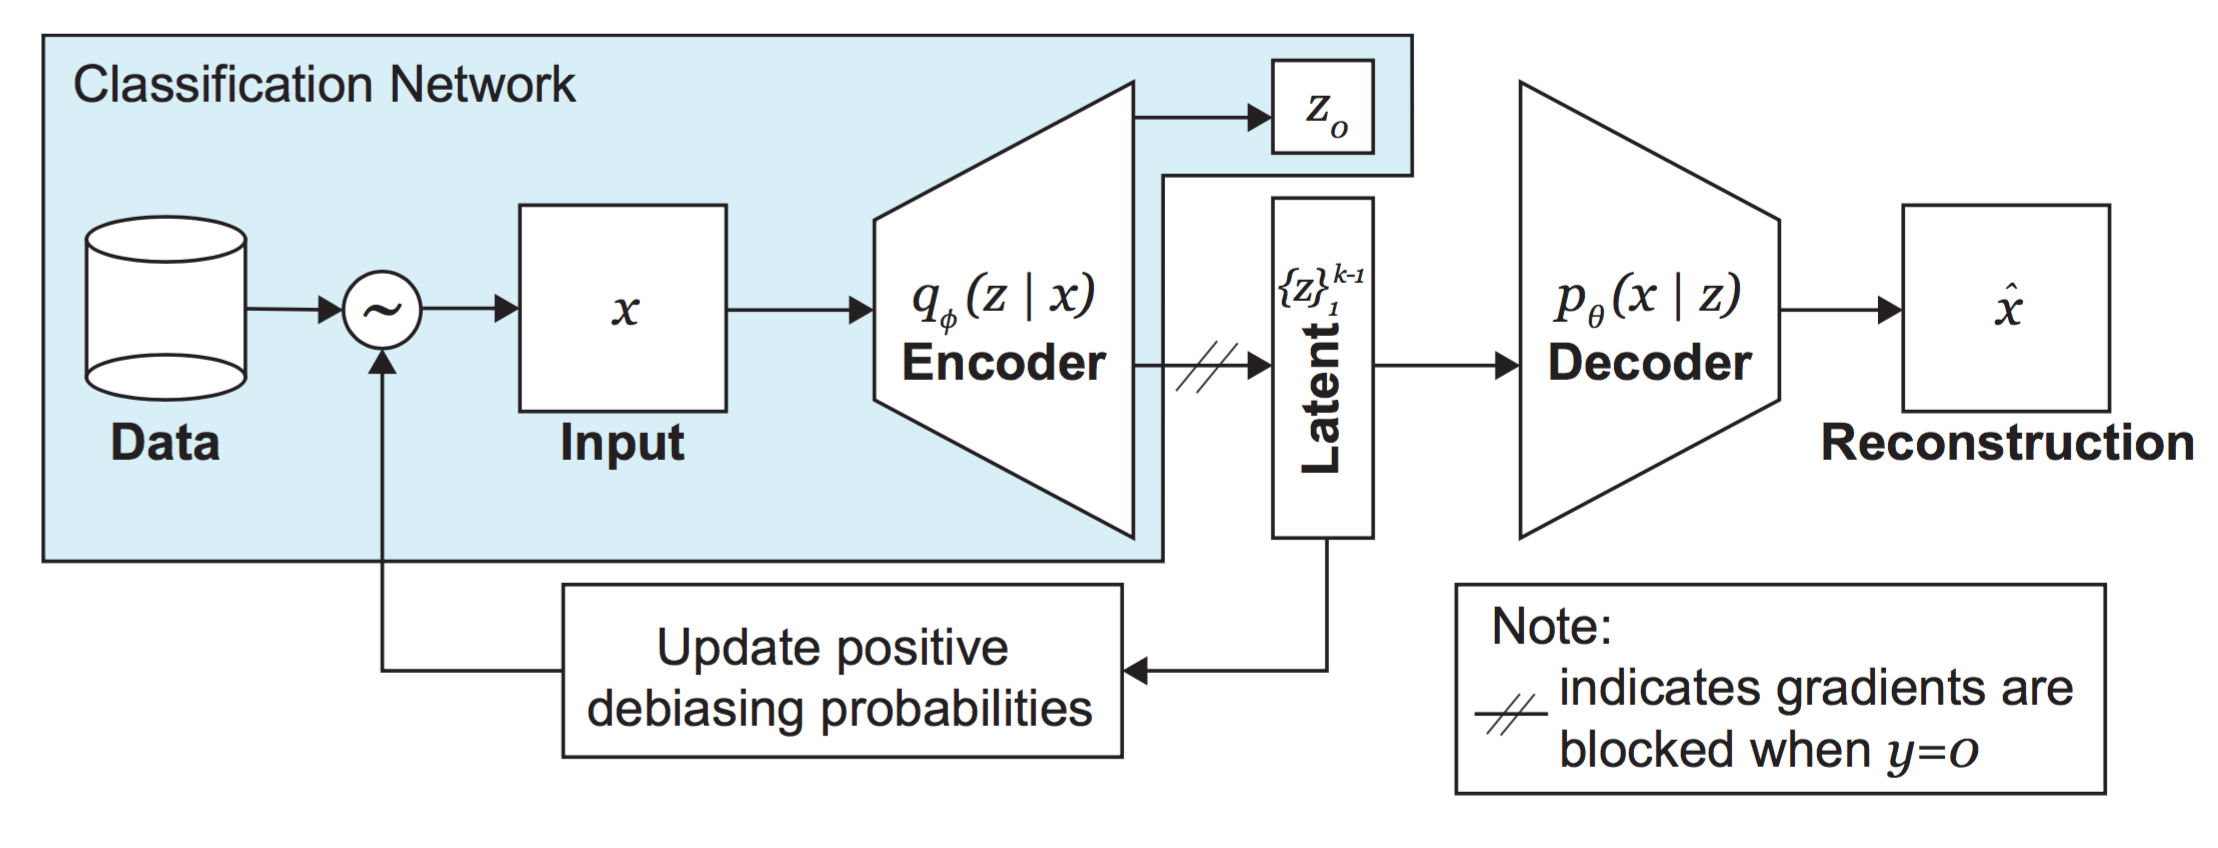

In [17]:
## Loss function for DB_VAE

def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    
    # VAE loss
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
    
    # Classification loss
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y.float())
    
    # Face indicator
    y = y.float()
    face_indicator = (y == 1).float()
    
    # Total loss
    total_loss = torch.mean(vae_loss + classification_loss)
    
    return total_loss, classification_loss

### DB-VAE architecture
Now we're ready to define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [18]:
class FaceDecoder(nn.Module):
    def __init__(self, latent_dim=100, n_filters=12):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 6 * n_filters),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(6 * n_filters, 4 * n_filters,
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(4 * n_filters, 2 * n_filters,
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(2 * n_filters, n_filters,
                               kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(n_filters, 3,
                               kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 6*12, 4, 4)  # 6*n_filters = 72
        x = self.deconv(x)
        return x


def make_face_decoder_network(latent_dim=100, n_filters=12):
    return FaceDecoder(latent_dim, n_filters)


Now, we will put this decoder together with the standard CNN classifier as our encoder to define the DB-VAE. Note that at this point, there is nothing special about how we put the model together that makes it a "debiasing" model -- that will come when we define the training operation. Here, we will define the core VAE architecture by sublassing nn.Module class; defining encoding, reparameterization, and decoding operations; and calling the network end-to-end.

In [19]:
class DB_VAE(nn.Module):

    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = make_standard_classifier(
            n_outputs = 2 * latent_dim + 1
        )

        # Decoder
        self.decoder = make_face_decoder_network(
            latent_dim=latent_dim
        )

    #  Encoder Split 
    def encode(self, x):

        encoder_output = self.encoder(x)

        # Classification logit
        y_logits = encoder_output[:, 0].unsqueeze(-1)

        # Latent mean
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]

        # Latent log sigma
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]

        return y_logits, z_mean, z_logsigma


    #  Reparameterization 
    def reparameterization(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma)
        return z


    #  Decoder 
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction


    #  Forward 
    def forward(self, x):

        y_logits, z_mean, z_logsigma = self.encode(x)

        z = self.reparameterization(z_mean, z_logsigma)

        recon = self.decode(z)

        return y_logits, z_mean, z_logsigma, recon


    # Predict 
    def predict(self, x):
        y_logits, _, _ = self.encode(x)
        return y_logits


# Create model
dbvae = DB_VAE(latent_dim=100)


As stated, the encoder architecture is identical to the CNN from earlier in this lab. Note the outputs of our constructed DB_VAE model in the forward function: y_logit, z_mean, z_logsigma, z. Think carefully about why each of these are outputted and their significance to the problem at hand.

## Adaptive resampling for automated debiasing with DB-VAE

In [20]:
def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []

    # Convert NumPy images to torch tensor
    images_t = torch.from_numpy(images).float()

    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end].to(device).permute(0, 3, 1, 2)  # [B, C, H, W]

            # Forward pass: unpack 4 outputs, only keep z_mean
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())

    # Concatenate all batches
    z_mean_full = torch.cat(all_z_mean, dim=0)  # shape [N, latent_dim]
    return z_mean_full.numpy()


Now, let's define the actual resampling algorithm get_training_sample_probabilities. Importantly note the argument smoothing_fac. This parameter tunes the degree of debiasing: for smoothing_fac=0, the re-sampled training set will tend towards falling uniformly over the latent space, i.e., the most extreme debiasing.

In [21]:

def get_training_sample_probabilities(images, dbvae, latent_dim=100, bins=10, smoothing_fac=0.001, batch_size=64):
    """
    Recompute the sampling probabilities for images based on latent space distribution.
    
    Args:
        images (np.array): Input images, shape [N, H, W, C]
        dbvae (nn.Module): Trained DB-VAE model
        latent_dim (int): Number of latent variables
        bins (int): Number of bins for histogram per latent dimension
        smoothing_fac (float): Small value to smooth histogram densities
        batch_size (int): Batch size for computing latent means
        
    Returns:
        training_sample_p (np.array): Probability for each image [N,]
    """
    print("Recomputing the sampling probabilities")

    #  Get latent means for all images
    mu = get_latent_mu(images, dbvae, batch_size=batch_size)  # shape [N, latent_dim]

    # Initialize sampling probabilities
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)

    # Loop over each latent dimension
    for i in range(latent_dim):
        latent_distribution = mu[:, i]

        #  Histogram of latent variable
        hist_density, bin_edges = np.histogram(latent_distribution, bins=bins, density=True)

        #  Extend edges to include extreme values
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")

        #  Determine which bin each sample falls into
        bin_idx = np.digitize(latent_distribution, bin_edges)

        #  Smooth density
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        #  Invert density → rare regions get higher probability
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])

        #  Normalize probabilities for this dimension
        p = p / np.sum(p)

        #  Combine probabilities: take maximum across latent dimensions
        training_sample_p = np.maximum(training_sample_p, p)

    # Final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to faces, not the set of negative examples. Complete the code block below to execute the training loop!

In [22]:
# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=2, 
)

# Instantiate DB-VAE and optimizer
dbvae = DB_VAE(params["latent_dim"]).to(device)
optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])

# Training step function
def debiasing_train_step(x, y):
    """
    One training step for the DB-VAE.
    - x: batch of images
    - y: batch of labels (0 or 1)
    """
    optimizer.zero_grad()  # reset gradients

    # Forward pass through DB-VAE
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    # Compute total DB-VAE loss (classification + VAE)
    loss, class_loss = debiasing_loss_function(
        x, x_recon, y, y_logit, z_mean, z_logsigma
    )

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss


# Get all positive face images from the loader
all_faces = loader.get_all_train_faces()  # numpy array of positive faces

# Training loop
for epoch in range(params["num_epochs"]):
    print(f"\nStarting epoch {epoch+1}/{params['num_epochs']}")

    # 1. Recompute sampling probabilities for adaptive debiasing
    # This step increases sampling for rare latent regions
    p_faces = get_training_sample_probabilities(
        all_faces, dbvae, bins=10, smoothing_fac=0.001
    )

    # 2. Train on each batch
    total_loss = 0.0
    total_class_loss = 0.0

    num_batches = loader.get_train_size() // params["batch_size"]
    for _ in range(num_batches):
        # Load a batch with resampling probabilities
        x, y = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # One training step
        loss = debiasing_train_step(x, y)

        # Update total loss for this epoch
        total_loss += loss.item() * x.size(0)

    # Compute average loss for the epoch
    avg_loss = total_loss / loader.get_train_size()
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")



Starting epoch 1/2
Recomputing the sampling probabilities
Epoch 1, Average Loss: 0.1709

Starting epoch 2/2
Recomputing the sampling probabilities
Epoch 2, Average Loss: 0.0999


# 2.6 Evaluation of DB-VAE on Test Dataset
Finally let's test our DB-VAE model on the test dataset, looking specifically at its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics. We will compare the performance of this debiased model against the (potentially biased) standard CNN.

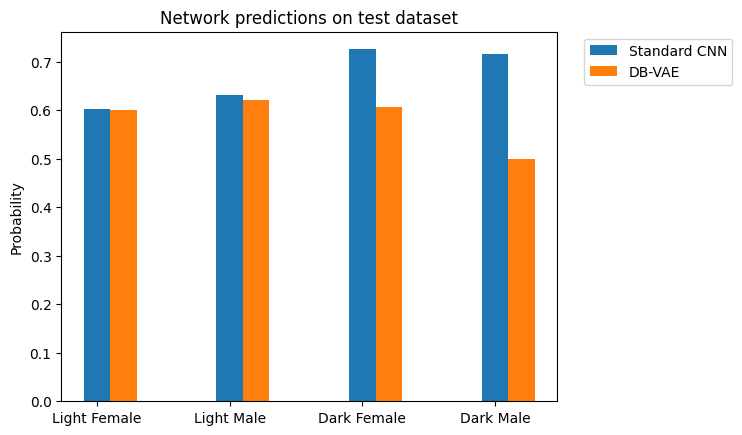

In [23]:
dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)

    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)

    dbvae_logits_list.append(logit.detach().cpu().numpy())

dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()

xx = np.arange(len(keys))

std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)

plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")

plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

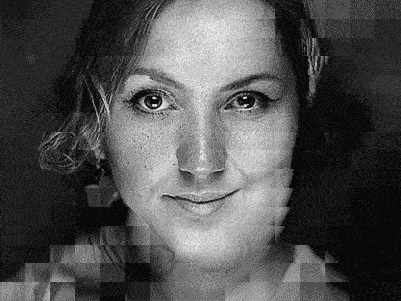

# Deployment

## save the model

In [24]:
torch.save(dbvae.state_dict(), "dbvae_weights.pth")